In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
# add project root dir to sys.path so that all packages can be found by python.
root_dir = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
sys.path.append(root_dir)

In [54]:
def get_metrics(filepath, instruments=["vocals", "accompaniment"]):
    with open(filepath, "rb") as f:
        test_metrics = pickle.load(f)
    SDRs = {inst: [np.nanmean(song[inst]["SDR"]) for song in test_metrics] for inst in instruments}
    SIRs = {inst: [np.nanmean(song[inst]["SIR"]) for song in test_metrics] for inst in instruments}
    avg_SDRs = {inst: np.mean(SDRs[inst]) for inst in instruments}
    avg_SIRs = {inst: np.mean(SIRs[inst]) for inst in instruments}
    return SDRs, SIRs, avg_SDRs, avg_SIRs

def plot_metric(metric, metric_name, instruments=["vocals", "accompaniment"], axs=None):
    if not axs:
        fig, axs = plt.subplots(nrows=len(instruments), ncols=1, figsize=(10, 6))
    for i, instrument in enumerate(instruments):
        axs[i].violinplot(metric[instrument],
                     showmeans=True, showextrema=True, showmedians=True)
        axs[i].set_title(f"{metric_name} for {instrument}")

In [55]:
SDRs, SIRs, avg_SDRs, avg_SIRs = get_metrics("results.pkl")

In [59]:
print(f"{avg_SDRs=}, {avg_SIRs=}")

avg_SDRs={'vocals': 5.06209574894545, 'accompaniment': 16.10385408758616}, avg_SIRs={'vocals': 16.06872272748571, 'accompaniment': 20.130520948456734}


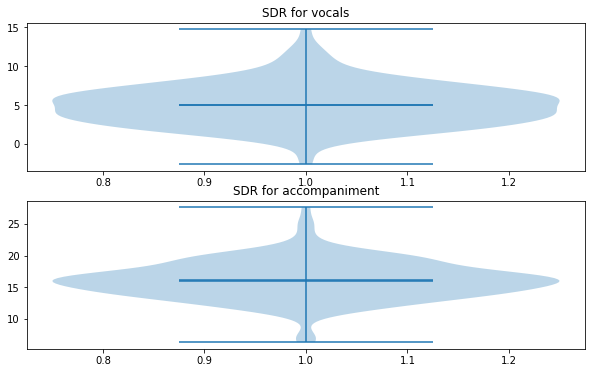

In [56]:
plot_metric(SDRs, "SDR")

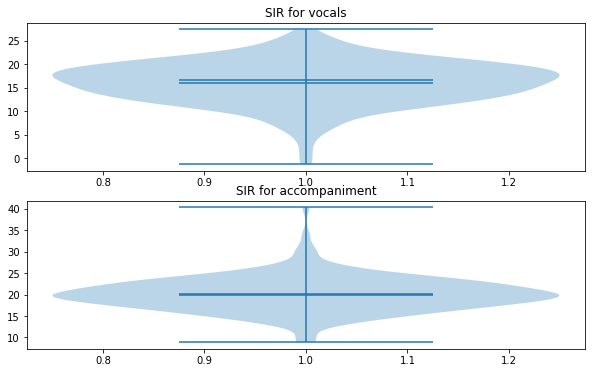

In [57]:
plot_metric(SIRs, "SIR")